Problem 10 (Chap 14). Use transfer learning for large image classification, going through these steps:

(a) Create a training set containing at least 100 images per class. For example, you could classify your own pictures based on the location (beach, mountain, city, etc.), or alternatively you can use an existing dataset (e.g., from TensorFlow Datasets).  You can use the flower data but see (b) 

(b) Split it into a training set, a validation set, and a test set.  (If you use the "flower data" from Chap 14, define the train/validation split (from the "non-test" dataset) through the  function train_test_split(X, y, random_state=num4). Set the random seed num4 to the last 4 digits of your student ID)

(c) Build the input pipeline, including the appropriate preprocessing operations, and optionally add data augmentation.  

(c) Fine-tune a pretrained model on this dataset.

In [50]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)



In [51]:
### IMporting the food images

In [52]:
pip install tensorflow_datasets

Note: you may need to restart the kernel to use updated packages.


In [53]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("beans", as_supervised=True, with_info=True)

In [54]:
info.splits

{'train': <SplitInfo num_examples=1034, num_shards=2>,
 'validation': <SplitInfo num_examples=133, num_shards=1>,
 'test': <SplitInfo num_examples=128, num_shards=1>}

In [55]:
class_names = info.features["label"].names
class_names

['angular_leaf_spot', 'bean_rust', 'healthy']

In [56]:
n_classes = info.features["label"].num_classes
n_classes

3

In [57]:
dataset_size = info.splits["train"].num_examples
dataset_size

1034

AttributeError: 'DatasetInfo' object has no attribute 'dtype'

In [37]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "beans",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

In [38]:
type(train_set_raw)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

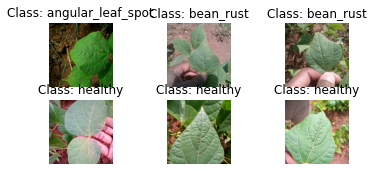

In [39]:
index = 0
for image, label in train_set_raw.take(6):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

Preprocessing without augmentations

In [40]:

def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label


In [41]:

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

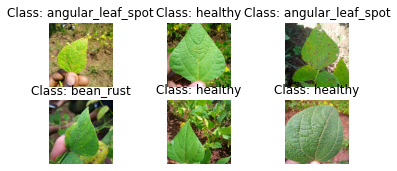

In [42]:
for X_batch, y_batch in train_set.take(1):
    for index in range(6):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [43]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [44]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_4
13 block2_pool
14 batch_normalization_4
15 add_12
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_5
23 block3_pool
24 batch_normalization_5
25 add_13
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_6
33 block4_pool
34 batch_normalization_6
35 add_14
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_15
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_se

In [45]:
## Freeze the weights of the layers from the pretrained model
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
24/24 [==============================] - 46s 2s/step - loss: 4.6412 - accuracy: 0.5104 - val_loss: 1.2290 - val_accuracy: 0.7891
Epoch 2/5
24/24 [==============================] - 44s 2s/step - loss: 0.8454 - accuracy: 0.8686 - val_loss: 1.0925 - val_accuracy: 0.7969
Epoch 3/5
24/24 [==============================] - 43s 2s/step - loss: 1.5824 - accuracy: 0.7914 - val_loss: 1.3183 - val_accuracy: 0.7812
Epoch 4/5
24/24 [==============================] - 43s 2s/step - loss: 0.8444 - accuracy: 0.8791 - val_loss: 0.9971 - val_accuracy: 0.8906
Epoch 5/5
24/24 [==============================] - 44s 2s/step - loss: 0.4815 - accuracy: 0.8992 - val_loss: 1.3169 - val_accuracy: 0.8516


Preprocessing with augmentation

> accuracy goes up by 1% only



In [46]:

from functools import partial

def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]


def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label


In [47]:
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [48]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_4
13 block2_pool
14 batch_normalization_4
15 add_12
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_5
23 block3_pool
24 batch_normalization_5
25 add_13
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_6
33 block4_pool
34 batch_normalization_6
35 add_14
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_15
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_se

In [49]:
## Freeze the weights of the layers from the pretrained model
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
24/24 [==============================] - 49s 2s/step - loss: 0.8531 - accuracy: 0.8545 - val_loss: 1.1807 - val_accuracy: 0.8594
Epoch 2/5
24/24 [==============================] - 44s 2s/step - loss: 0.8176 - accuracy: 0.8507 - val_loss: 0.7686 - val_accuracy: 0.8828
Epoch 3/5
24/24 [==============================] - 42s 2s/step - loss: 0.6446 - accuracy: 0.8898 - val_loss: 1.0126 - val_accuracy: 0.7969
Epoch 4/5
24/24 [==============================] - 41s 2s/step - loss: 0.8068 - accuracy: 0.8685 - val_loss: 1.0329 - val_accuracy: 0.8281
Epoch 5/5
24/24 [==============================] - 42s 2s/step - loss: 0.6775 - accuracy: 0.8753 - val_loss: 0.6262 - val_accuracy: 0.8594
